In [1]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

In [2]:
%%appyter code_exec

{% do SectionField(
    name='Datasets',
    title='Datasets',
    subtitle='RNA predictions'
)%}

gene = {{ AutocompleteField(
    name='autocomplete',
    label='autocomplete',
    description='autocomplete',
    section='Datasets',
    default='TSPAN6'
)}}

```python

gene = 'TSPAN6'
```

In [416]:
import h5py
import pandas as pd
import numpy as np
from tqdm import trange, tqdm
from scipy.stats import zscore
import urllib.request
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot
from IPython.display import clear_output, display_html, HTML 
import requests
import os
from maayanlab_bioinformatics.harmonization import ncbi_genes

# Fetch and load data

Fetch and load prepared TCGA correlation matrix into a DataFrame - 38550 coding and noncoding genes

In [2]:
url = 'https://appyters.maayanlab.cloud/storage/ncRNA_predictions/tcga.h5'
if not os.path.exists("tcga.h5"):
    with open("tcga.h5", 'wb') as fout:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        chunk = 400*1024**2
        file_size = int(response.headers["Content-Length"])
        bars = int(file_size/chunk)
        for block in tqdm(response.iter_content(chunk), total=bars, desc="Loading TCGA correlation matrix"):
            fout.write(block)

In [3]:
f = h5py.File("tcga.h5", "r")
tcga_genes = [str(g[0])[2:-1] for g in f['tcga_genes']]
filtered_genes = [str(g[0])[2:-1] for g in f['filtered_genes']] # only genes found in gene set libraries
tcga_cor = pd.DataFrame(np.array(f['corr_matrix']), index=tcga_genes, columns=filtered_genes) 

Fetch and load prepared ARCHS4 human correlation matrix into a DataFrame - 26415 coding genes

In [4]:
url = 'https://s3.amazonaws.com/mssm-data/human_correlation_archs4.f'
if not os.path.exists("human_correlation_archs4"):
    with open("human_correlation_archs4", 'wb') as fout:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        chunk = 400*1024**2
        file_size = int(response.headers["Content-Length"])
        bars = int(file_size/chunk)
        for block in tqdm(response.iter_content(chunk), total=bars, desc="Loading ARCHS4 correlation matrix"):
            fout.write(block)

In [5]:
archs4_cor = pd.read_feather("human_correlation_archs4")
archs4_genes = list(archs4_cor.columns) 
archs4_cor.index = archs4_genes
np.fill_diagonal(archs4_cor.values, 0)

Fetch reference prediction matrices prepared from Enrichr [gene set libraries](https://amp.pharm.mssm.edu/Enrichr/#stats).

In [6]:
url = 'https://appyters.maayanlab.cloud/storage/ncRNA_predictions/gene_set_libraries'
if not os.path.exists("gene_set_libraries"):
    with open("gene_set_libraries", 'wb') as fout:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        chunk = 400*1024**2
        file_size = int(response.headers["Content-Length"])
        bars = int(file_size/chunk)
        for block in tqdm(response.iter_content(chunk), total=bars, desc="Loading gene set libraries"):
            fout.write(block)

In [7]:
libraries = ['GO_Biological_Process_2018', 'ChEA_2016', 'MGI_Mammalian_Phenotype_Level_4_2019', 'KEGG_2019_Human',
              'KEA_2015', 'Human_Phenotype_Ontology']

In [8]:
gene = "TSPAN6"

# Predicting the top correlated functions and genes

In this section, we define a pipeline with functions that will determine the top functions correlated to the user-inputted gene for each Enrichr library, and the top correlated genes, for both TCGA and ARCHS4.

Given a gene set library's name, pull the library from Enrichr and return a dictionary with functions as keys and genes as values and a sorted set of the gene set library's genes.

In [9]:
def gene_set_dictionaries(library):
    print("Creating dictionary from %s." % library)
    enrichr_url = 'https://amp.pharm.mssm.edu/Enrichr/geneSetLibrary?mode=text&libraryName='
    data = urllib.request.urlopen(enrichr_url + library)
    function_to_genes = {}
    gene_set = set() 
    for line in data:
        lst = (str(line.strip())[2:-1]).split(r'\t')
        function = lst[0]
        genes = lst[2:]
        function_to_genes[function] = genes
        gene_set.update(set(genes))
    clear_output()
    print("Completed creating dictionary from %s." % library)
    return function_to_genes, sorted(gene_set)

Given the function-to-gene dictionary and set of genes from the above function, create a binary matrix with genes as rows and functions as columns (value of 1 means the gene is associated with the given function).

In [10]:
def gs_binary_matrix(function_to_genes, gene_set):
    print("Creating binary matrix.")
    binary_matrix = np.zeros((len(gene_set), len(function_to_genes)))
    binary_matrix = pd.DataFrame(data=binary_matrix, index=gene_set, columns=list(function_to_genes.keys()))
    for function in binary_matrix.columns: 
        gene_list = function_to_genes[function]
        binary_matrix.loc[gene_list, function] += 1
    clear_output()
    print("Completed creating binary matrix.")
    return binary_matrix

Given the library name as well as the function-to-gene dictionary and gene set from above, load the gene set prediction matrix as a DataFrame with genes as rows, functions as columns. In this prediction matrix, in each (gene, gene set/function) cell is the correlation of that gene for a given gene set (function) to every other gene in that gene set.

In [11]:
def gene_set_library(library, function_to_genes, gene_set):
    f = h5py.File("gene_set_libraries", "r")
    gslib = pd.DataFrame(np.array(f[library]['gslib']), index=gene_set, columns=list(function_to_genes.keys())) 
    f.close()
    clear_output()
    print("Completed creating gene set prediction matrix.")
    return gslib

Generate a new prediction matrix combining the gene set prediction matrix above and the TCGA or ARCHS4 correlation matrix. The following formula is used to make predictions about the chosen gene using the TCGA or ARCHS4 correlation matrix.

<div style=margin-top:20px> 
    <img src="static/geneshot_formula.png" width="50%" height="50%" style='border:0.1px solid light gray' />
    <div style=text-align:center;margin-top:20px> 
        Fig. 1: Formula found in the <a href='https://academic.oup.com/nar/article/47/W1/W571/5494749'>Geneshot paper</a> to calculate the prediction matrix. G is the correlation matrix, GF is the gene set prediction matrix, and GF' is the new prediction matrix to make predictions about the given dataset. Note: the denominator should be GF instead of G.
    </div>
</div>

In [12]:
def prediction_matrix(gene, cor_matrix, gslib):
    idx = [ g for g in gslib.index if g in cor_matrix.columns ]
    smaller_cor = cor_matrix.loc[gene, idx] 
    smaller_gslib = gslib.loc[idx]
    pred_matrix = np.dot(smaller_cor, smaller_gslib)
    if gene in smaller_gslib.index: smaller_gslib = smaller_gslib.drop(index=gene)
    function_sums = np.array(np.sum(smaller_gslib))
    pred_matrix /= function_sums
    return pd.DataFrame(data=np.transpose(pred_matrix), index=gslib.columns, columns=[gene])

Return the top 50 most correlated functions and 100 most correlated genes associated with the given gene.

In [417]:
def top_ranked(matrix, gene, rank): 
    top = matrix.sort_values(ascending=False).head(rank)
    z_scores = pd.DataFrame(zscore(top), index=top.index)
    genes = pd.DataFrame(list(top.index), index=top.index)
    top = pd.concat([genes, top, z_scores], axis=1)
    top.index = list(range(1, rank+1))
    return top

In [418]:
def get_top_functions(matrix, gene, name):
    top = top_ranked(matrix.loc[:,gene], gene, 50)
    top.columns = ["%s - Annotation" % name, "%s - Score" % name, "%s - Z-Score" % name]
    return top

In [483]:
def get_top_genes(matrix, gene, name):
    top = top_ranked(matrix.T.loc[gene], gene, 100)
    top.columns = ["%s - Gene" % name, "%s - Score" % name, "%s - Z-Score" % name]
    ncbi = pd.DataFrame(ncbi_genes.ncbi_genes_fetch())
    all_symbols = ncbi.Symbol.values
    ncbi = ncbi[["type_of_gene"]]
    ncbi["Symbol"] = all_symbols
    ncbi = ncbi.set_index("Symbol")
    symbol_to_gene_type = ncbi.to_dict()["type_of_gene"]
    def id_to_type(key):
        if (key in symbol_to_gene_type):
            return symbol_to_gene_type[key]
        else:
            return None
    gene_types = np.transpose([ id_to_type(key) for key in top.loc[:, '%s - Gene' % name ]])
    filtered_types = gene_types[gene_types!=None]
    counts = np.unique(filtered_types, return_counts=True)
    return top, counts

Graph the AUROC for the TCGA and ARCHS4 predictions.

In [52]:
def auc(y_true, tcga_probs, archs4_probs, gene):
    ns_probs = [0 for _ in range(len(y_true))]
    fpr, tpr, _ = roc_curve(y_true, tcga_probs)
    apr, bpr, _ = roc_curve(y_true, archs4_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
    tcga_auc = roc_auc_score(y_true, tcga_probs)
    archs4_auc = roc_auc_score(y_true, archs4_probs)
    pyplot.figure(figsize=(11,5))
    pyplot.subplot(1,2,1)
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
    pyplot.plot(fpr, tpr, marker='.')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.title("TCGA: " + gene)
    pyplot.text(0.75, 0.05, 'AUC: %.3f' % tcga_auc, fontsize=12)
    
    pyplot.subplot(1,2,2)
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
    pyplot.plot(apr, bpr, marker='.')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.title("ARCHS4: " + gene)
    pyplot.text(0.75, 0.05, 'AUC: %.3f' % archs4_auc, fontsize=12)
    pyplot.tight_layout()
    pyplot.show()

Process to determine top correlated functions using the above functions, and display DataFrames alongside each other to facilitate comparison.

In [507]:
def functional_comparison(current_lib, tcga_cor, archs4_cor):
    function_to_genes, gene_set = gene_set_dictionaries(current_lib)
    binary_matrix = gs_binary_matrix(function_to_genes, gene_set)
    gslib = gene_set_library(current_lib, function_to_genes, gene_set)
    tcga_pred_matrix = prediction_matrix(gene, tcga_cor, gslib)
    clear_output()
    print("Completed creating TCGA prediction matrix.")
    archs4_pred_matrix = prediction_matrix(gene, archs4_cor, gslib)
    clear_output()
    print("Completed creating ARCHS4 prediction matrix.")
    top_tcga_functions = get_top_functions(tcga_pred_matrix, gene, "TCGA")
    top_archs4_functions = get_top_functions(archs4_pred_matrix, gene, "ARCHS4")
    clear_output() 
    combined_df = pd.concat([top_tcga_functions, top_archs4_functions], axis=1)
    display_df(combined_df)
    return binary_matrix, tcga_pred_matrix, archs4_pred_matrix

In [510]:
def display_df(df):
    n = df.style.set_table_attributes("style='max-width:95%;margin:auto'")
    display_html(n._repr_html_(), raw=True)

# Predicted pathways (GO)

Side-by-side comparison of the top predicted pathways.

In [368]:
binary_matrix, tcga_pred_matrix, archs4_pred_matrix = functional_comparison(libraries[0], tcga_cor, archs4_cor)

TCGA - Annotation TCGA - Score TCGA - Z-Score ARCHS4 - Annotation ARCHS4 - Score ARCHS4 - Z-Score 
 
 1 
 tryptophan catabolic process (GO:0006569) 
 3.143288 
 6.033905 
 tryptophan catabolic process (GO:0006569) 
 0.256529 
 2.702348 
 
 
 2 
 indolalkylamine catabolic process (GO:0046218) 
 1.288079 
 1.879734 
 ubiquinone metabolic process (GO:0006743) 
 0.253028 
 2.638279 
 
 
 3 
 succinyl-CoA metabolic process (GO:0006104) 
 1.000186 
 1.235086 
 quinone biosynthetic process (GO:1901663) 
 0.253028 
 2.638279 
 
 
 4 
 flavonoid glucuronidation (GO:0052696) 
 0.822875 
 0.838053 
 protein C-linked glycosylation via tryptophan (GO:0018317) 
 0.220741 
 2.047338 
 
 
 5 
 ethanol catabolic process (GO:0006068) 
 0.738542 
 0.649214 
 protein C-linked glycosylation via 2'-alpha-mannosyl-L-tryptophan (GO:0018406) 
 0.220741 
 2.047338 
 
 
 6 
 ethanol metabolic process (GO:0006067) 
 0.738542 
 0.649214 
 ketone body metabolic process (GO:1902224) 
 0.191217 
 1.506964 
 
 
 7 
 glucuronate metabolic process (GO:0019585) 
 0.698396 
 0.559320 
 flavonoid glucuronidation (GO:0052696) 
 0.171839 
 1.152292 
 
 
 8 
 xenobiotic glucuronidation (GO:0052697) 
 0.691710 
 0.544349 
 nucleotide phosphorylation (GO:0046939) 
 0.162566 
 0.982572 
 
 
 9 
 ketone body metabolic process (GO:1902224) 
 0.675301 
 0.507606 
 succinyl-CoA metabolic process (GO:0006104) 
 0.154935 
 0.842912 
 
 
 10 
 cellular glucuronidation (GO:0052695) 
 0.670866 
 0.497675 
 ketone body biosynthetic process (GO:0046951) 
 0.142656 
 0.618174 
 
 
 11 
 ketone body biosynthetic process (GO:0046951) 
 0.521301 
 0.162771 
 xenobiotic glucuronidation (GO:0052697) 
 0.134878 
 0.475805 
 
 
 12 
 coumarin metabolic process (GO:0009804) 
 0.509825 
 0.137073 
 ubiquinone biosynthetic process (GO:0006744) 
 0.133940 
 0.458641 
 
 
 13 
 monoterpenoid metabolic process (GO:0016098) 
 0.489607 
 0.091802 
 indolalkylamine catabolic process (GO:0046218) 
 0.130038 
 0.387220 
 
 
 14 
 tyrosine metabolic process (GO:0006570) 
 0.442001 
 -0.014798 
 glucuronate metabolic process (GO:0019585) 
 0.128103 
 0.351821 
 
 
 15 
 terpenoid metabolic process (GO:0006721) 
 0.383697 
 -0.145352 
 cellular glucuronidation (GO:0052695) 
 0.122622 
 0.251503 
 
 
 16 
 cellular lipid biosynthetic process (GO:0097384) 
 0.370689 
 -0.174478 
 ATP synthesis coupled electron transport (GO:0042773) 
 0.119952 
 0.202621 
 
 
 17 
 ribonucleoside bisphosphate biosynthetic process (GO:0034030) 
 0.362768 
 -0.192215 
 coumarin metabolic process (GO:0009804) 
 0.116130 
 0.132668 
 
 
 18 
 purine nucleoside bisphosphate biosynthetic process (GO:0034033) 
 0.362768 
 -0.192215 
 monoterpenoid metabolic process (GO:0016098) 
 0.108396 
 -0.008886 
 
 
 19 
 coenzyme A biosynthetic process (GO:0015937) 
 0.362768 
 -0.192215 
 outer dynein arm assembly (GO:0036158) 
 0.107920 
 -0.017597 
 
 
 20 
 estrogen biosynthetic process (GO:0006703) 
 0.361743 
 -0.194510 
 inner dynein arm assembly (GO:0036159) 
 0.105610 
 -0.059872 
 
 
 21 
 glucocorticoid biosynthetic process (GO:0006704) 
 0.342365 
 -0.237901 
 cellular lipid biosynthetic process (GO:0097384) 
 0.100152 
 -0.159759 
 
 
 22 
 ubiquinone metabolic process (GO:0006743) 
 0.341273 
 -0.240347 
 centromeric sister chromatid cohesion (GO:0070601) 
 0.092492 
 -0.299964 
 
 
 23 
 quinone biosynthetic process (GO:1901663) 
 0.341273 
 -0.240347 
 coenzyme A biosynthetic process (GO:0015937) 
 0.092189 
 -0.305509 
 
 
 24 
 tryptophan metabolic process (GO:0006568) 
 0.328914 
 -0.268022 
 purine nucleoside bisphosphate biosynthetic process (GO:0034033) 
 0.092189 
 -0.305509 
 
 
 25 
 lipid hydroxylation (GO:0002933) 
 0.308409 
 -0.313935 
 ribonucleoside bisphosphate biosynthetic process (GO:0034030) 
 0.092189 
 -0.305509 
 
 
 26 
 fatty acid beta-oxidation using acyl-CoA dehydrogenase (GO:0033539) 
 0.300729 
 -0.331132 
 regulation of cilium movement (GO:0003352) 
 0.085934 
 -0.419993 
 
 
 27 
 mineralocor

In [369]:
binary_matrix, tcga_pred_matrix, archs4_pred_matrix = functional_comparison(libraries[0], tcga_cor, archs4_cor)

TCGA - Annotation TCGA - Score TCGA - Z-Score ARCHS4 - Annotation ARCHS4 - Score ARCHS4 - Z-Score 
 
 1 
 tryptophan catabolic process (GO:0006569) 
 3.143288 
 6.033905 
 tryptophan catabolic process (GO:0006569) 
 0.256529 
 2.702348 
 
 
 2 
 indolalkylamine catabolic process (GO:0046218) 
 1.288079 
 1.879734 
 ubiquinone metabolic process (GO:0006743) 
 0.253028 
 2.638279 
 
 
 3 
 succinyl-CoA metabolic process (GO:0006104) 
 1.000186 
 1.235086 
 quinone biosynthetic process (GO:1901663) 
 0.253028 
 2.638279 
 
 
 4 
 flavonoid glucuronidation (GO:0052696) 
 0.822875 
 0.838053 
 protein C-linked glycosylation via tryptophan (GO:0018317) 
 0.220741 
 2.047338 
 
 
 5 
 ethanol catabolic process (GO:0006068) 
 0.738542 
 0.649214 
 protein C-linked glycosylation via 2'-alpha-mannosyl-L-tryptophan (GO:0018406) 
 0.220741 
 2.047338 
 
 
 6 
 ethanol metabolic process (GO:0006067) 
 0.738542 
 0.649214 
 ketone body metabolic process (GO:1902224) 
 0.191217 
 1.506964 
 
 
 7 
 glucuronate metabolic process (GO:0019585) 
 0.698396 
 0.559320 
 flavonoid glucuronidation (GO:0052696) 
 0.171839 
 1.152292 
 
 
 8 
 xenobiotic glucuronidation (GO:0052697) 
 0.691710 
 0.544349 
 nucleotide phosphorylation (GO:0046939) 
 0.162566 
 0.982572 
 
 
 9 
 ketone body metabolic process (GO:1902224) 
 0.675301 
 0.507606 
 succinyl-CoA metabolic process (GO:0006104) 
 0.154935 
 0.842912 
 
 
 10 
 cellular glucuronidation (GO:0052695) 
 0.670866 
 0.497675 
 ketone body biosynthetic process (GO:0046951) 
 0.142656 
 0.618174 
 
 
 11 
 ketone body biosynthetic process (GO:0046951) 
 0.521301 
 0.162771 
 xenobiotic glucuronidation (GO:0052697) 
 0.134878 
 0.475805 
 
 
 12 
 coumarin metabolic process (GO:0009804) 
 0.509825 
 0.137073 
 ubiquinone biosynthetic process (GO:0006744) 
 0.133940 
 0.458641 
 
 
 13 
 monoterpenoid metabolic process (GO:0016098) 
 0.489607 
 0.091802 
 indolalkylamine catabolic process (GO:0046218) 
 0.130038 
 0.387220 
 
 
 14 
 tyrosine metabolic process (GO:0006570) 
 0.442001 
 -0.014798 
 glucuronate metabolic process (GO:0019585) 
 0.128103 
 0.351821 
 
 
 15 
 terpenoid metabolic process (GO:0006721) 
 0.383697 
 -0.145352 
 cellular glucuronidation (GO:0052695) 
 0.122622 
 0.251503 
 
 
 16 
 cellular lipid biosynthetic process (GO:0097384) 
 0.370689 
 -0.174478 
 ATP synthesis coupled electron transport (GO:0042773) 
 0.119952 
 0.202621 
 
 
 17 
 ribonucleoside bisphosphate biosynthetic process (GO:0034030) 
 0.362768 
 -0.192215 
 coumarin metabolic process (GO:0009804) 
 0.116130 
 0.132668 
 
 
 18 
 purine nucleoside bisphosphate biosynthetic process (GO:0034033) 
 0.362768 
 -0.192215 
 monoterpenoid metabolic process (GO:0016098) 
 0.108396 
 -0.008886 
 
 
 19 
 coenzyme A biosynthetic process (GO:0015937) 
 0.362768 
 -0.192215 
 outer dynein arm assembly (GO:0036158) 
 0.107920 
 -0.017597 
 
 
 20 
 estrogen biosynthetic process (GO:0006703) 
 0.361743 
 -0.194510 
 inner dynein arm assembly (GO:0036159) 
 0.105610 
 -0.059872 
 
 
 21 
 glucocorticoid biosynthetic process (GO:0006704) 
 0.342365 
 -0.237901 
 cellular lipid biosynthetic process (GO:0097384) 
 0.100152 
 -0.159759 
 
 
 22 
 ubiquinone metabolic process (GO:0006743) 
 0.341273 
 -0.240347 
 centromeric sister chromatid cohesion (GO:0070601) 
 0.092492 
 -0.299964 
 
 
 23 
 quinone biosynthetic process (GO:1901663) 
 0.341273 
 -0.240347 
 coenzyme A biosynthetic process (GO:0015937) 
 0.092189 
 -0.305509 
 
 
 24 
 tryptophan metabolic process (GO:0006568) 
 0.328914 
 -0.268022 
 purine nucleoside bisphosphate biosynthetic process (GO:0034033) 
 0.092189 
 -0.305509 
 
 
 25 
 lipid hydroxylation (GO:0002933) 
 0.308409 
 -0.313935 
 ribonucleoside bisphosphate biosynthetic process (GO:0034030) 
 0.092189 
 -0.305509 
 
 
 26 
 fatty acid beta-oxidation using acyl-CoA dehydrogenase (GO:0033539) 
 0.300729 
 -0.331132 
 regulation of cilium movement (GO:0003352) 
 0.085934 
 -0.419993 
 
 
 27 
 mineralocor

AUROC for the TCGA and ARCHS4-generated predictions.

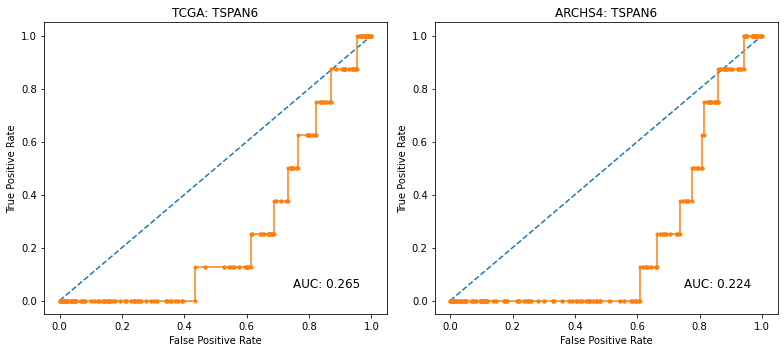

In [370]:
if gene in binary_matrix.index: auc(binary_matrix.loc[gene], tcga_pred_matrix, archs4_pred_matrix, gene)
else: print("Not enough gene annotations available.")

# Predicted upstream transcription factors (ChEA)

Side-by-side comparison of the top predicted upstream transcription factors.

In [371]:
binary_matrix, tcga_pred_matrix, archs4_pred_matrix = functional_comparison(libraries[1], tcga_cor, archs4_cor)

TCGA - Annotation TCGA - Score TCGA - Z-Score ARCHS4 - Annotation ARCHS4 - Score ARCHS4 - Z-Score 
 
 1 
 TRIM28 17542650 ChIP-ChIP NTERA2 Human 
 0.157950 
 3.373550 
 TRIM28 17542650 ChIP-ChIP NTERA2 Human 
 0.023306 
 6.004286 
 
 
 2 
 EED 16625203 ChIP-ChIP MESCs Mouse 
 0.125763 
 2.018699 
 FLI1 27457419 Chip-Seq LIVER Mouse 
 0.010303 
 1.438953 
 
 
 3 
 SUZ12 16625203 ChIP-ChIP MESCs Mouse 
 0.113410 
 1.498733 
 PCGF2 27294783 Chip-Seq ESCs Mouse 
 0.009472 
 1.147269 
 
 
 4 
 SUZ12 18555785 ChIP-Seq MESCs Mouse 
 0.108960 
 1.311391 
 RBPJ 22232070 ChIP-Seq NCS Mouse 
 0.008874 
 0.937082 
 
 
 5 
 PHC1 16625203 ChIP-ChIP MESCs Mouse 
 0.108238 
 1.281000 
 GLI1 17442700 ChIP-ChIP MESCs Mouse 
 0.008284 
 0.730077 
 
 
 6 
 EZH2 18974828 ChIP-Seq MESCs Mouse 
 0.107585 
 1.253546 
 VDR 22108803 ChIP-Seq LS180 Human 
 0.007909 
 0.598570 
 
 
 7 
 RNF2 18974828 ChIP-Seq MESCs Mouse 
 0.107585 
 1.253546 
 EST1 17652178 ChIP-ChIP JURKAT Human 
 0.007884 
 0.589694 
 
 
 8 
 JARID2 20064375 ChIP-Seq MESCs Mouse 
 0.104605 
 1.128104 
 ZFP57 27257070 Chip-Seq ESCs Mouse 
 0.007751 
 0.543017 
 
 
 9 
 SUZ12 18692474 ChIP-Seq MESCs Mouse 
 0.104572 
 1.126699 
 CREB1 15753290 ChIP-ChIP HEK293T Human 
 0.007706 
 0.527000 
 
 
 10 
 EZH2 27304074 Chip-Seq ESCs Mouse 
 0.104441 
 1.121198 
 SUZ12 27294783 Chip-Seq NPCs Mouse 
 0.007586 
 0.484859 
 
 
 11 
 SUZ12 18692474 ChIP-Seq MEFs Mouse 
 0.104256 
 1.113397 
 GABP 17652178 ChIP-ChIP JURKAT Human 
 0.007379 
 0.412244 
 
 
 12 
 RNF2 16625203 ChIP-ChIP MESCs Mouse 
 0.101413 
 0.993735 
 PCGF2 27294783 Chip-Seq NPCs Mouse 
 0.007006 
 0.281492 
 
 
 13 
 SUZ12 18974828 ChIP-Seq MESCs Mouse 
 0.101039 
 0.977996 
 NFE2 27457419 Chip-Seq LIVER Mouse 
 0.006928 
 0.254007 
 
 
 14 
 JARID2 20075857 ChIP-Seq MESCs Mouse 
 0.098991 
 0.891781 
 POU3F2 20337985 ChIP-ChIP 501MEL Human 
 0.006916 
 0.249886 
 
 
 15 
 CBX2 27304074 Chip-Seq ESCs Mouse 
 0.091314 
 0.568645 
 KDM6A 18722178 ChIP-ChIP U937 AND SAOS2 Human 
 0.006779 
 0.201768 
 
 
 16 
 BMI1 23680149 ChIP-Seq NPCS Mouse 
 0.088378 
 0.445030 
 TAF15 26573619 Chip-Seq HEK293 Human 
 0.006711 
 0.177798 
 
 
 17 
 RNF2 27304074 Chip-Seq ESCs Mouse 
 0.083834 
 0.253776 
 FUS 26573619 Chip-Seq HEK293 Human 
 0.006109 
 -0.033708 
 
 
 18 
 TP53 20018659 ChIP-ChIP R1E Mouse 
 0.081378 
 0.150410 
 NANOG 18555785 Chip-Seq ESCs Mouse 
 0.005813 
 -0.137459 
 
 
 19 
 MTF2 20144788 ChIP-Seq MESCs Mouse 
 0.081341 
 0.148858 
 EBF1 22473956 ChIP-Seq BONE MARROW Mouse 
 0.005701 
 -0.176911 
 
 
 20 
 EZH2 27294783 Chip-Seq ESCs Mouse 
 0.079944 
 0.090022 
 TCFCP2L1 18555785 Chip-Seq ESCs Mouse 
 0.005687 
 -0.181699 
 
 
 21 
 GLI1 17442700 ChIP-ChIP MESCs Mouse 
 0.079442 
 0.068896 
 IGF1R 20145208 ChIP-Seq DFB Human 
 0.005611 
 -0.208304 
 
 
 22 
 SUZ12 27294783 Chip-Seq ESCs Mouse 
 0.079058 
 0.052724 
 P300 19829295 ChIP-Seq ESCs Human 
 0.005610 
 -0.208837 
 
 
 23 
 RNF2 27304074 Chip-Seq NSC Mouse 
 0.071493 
 -0.265681 
 P53 22387025 ChIP-Seq ESCs Mouse 
 0.005498 
 -0.248166 
 
 
 24 
 SUZ12 20075857 ChIP-Seq MESCs Mouse 
 0.071269 
 -0.275124 
 GBX2 23144817 ChIP-Seq PC3 Human 
 0.005323 
 -0.309667 
 
 
 25 
 RING1B 27294783 Chip-Seq ESCs Mouse 
 0.067345 
 -0.440297 
 EZH2 27294783 Chip-Seq NPCs Mouse 
 0.005233 
 -0.341062 
 
 
 26 
 RBPJ 22232070 ChIP-Seq NCS Mouse 
 0.065616 
 -0.513052 
 CMYC 18555785 Chip-Seq ESCs Mouse 
 0.005203 
 -0.351761 
 
 
 27 
 POU5F1 16153702 ChIP-ChIP HESCs Human 
 0.064823 
 -0.546450 
 POU5F1 16153702 ChIP-ChIP HESCs Human 
 0.005177 
 -0.360740 
 
 
 28 
 EZH2 22144423 ChIP-Seq EOC Human 
 0.064329 
 -0.567243 
 E2F1 18555785 Chip-Seq ESCs Mouse 
 0.005125 
 -0.379166 
 
 
 29 
 TRIM28 21343339 ChIP-Seq HEK293 Human 
 0.064197 
 -0.572781 
 STAT3 18555785 Chip-Seq ESCs Mouse 
 0.005101 
 -0.387448 
 
 
 30 
 ZFP57 27257070 Chip-Seq ESCs Mouse 
 0.063973 
 -0.582241 
 CTBP2 25329375 ChIP-Seq LNCAP Human 
 0.005073 
 -0.397224 
 
 
 31 
 TAL1 26923725 Chip-Seq MACR

AUROC for the TCGA and ARCHS4-generated predictions.

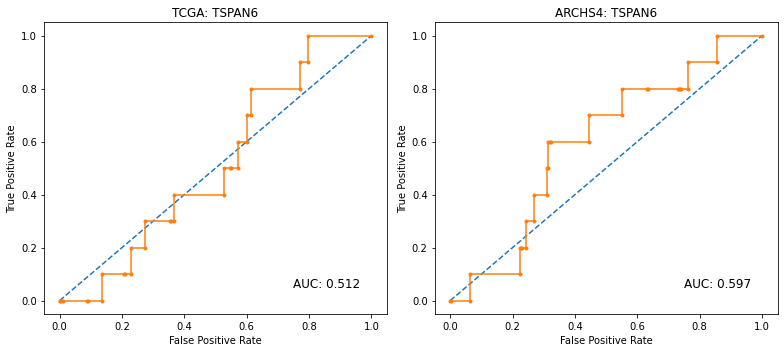

In [372]:
if gene in binary_matrix.index: auc(binary_matrix.loc[gene], tcga_pred_matrix, archs4_pred_matrix, gene)
else: print("Not enough gene annotations available.")

# Predicted mouse phenotypes (MGI)

Side-by-side comparison of the top predicted mouse phenotypes.

In [373]:
binary_matrix, tcga_pred_matrix, archs4_pred_matrix = functional_comparison(libraries[2], tcga_cor, archs4_cor)

TCGA - Annotation TCGA - Score TCGA - Z-Score ARCHS4 - Annotation ARCHS4 - Score ARCHS4 - Z-Score 
 
 1 
 MP:0004525 thin cochlear hair cell stereocilia 
 0.119713 
 5.279213 
 MP:0005411 delayed fertilization 
 0.026390 
 2.542518 
 
 
 2 
 MP:0004292 abnormal spiral ligament fibrocyte morphology 
 0.095269 
 2.121183 
 MP:0013987 absent intrahepatic inferior vena cava segment 
 0.025918 
 2.394310 
 
 
 3 
 MP:0004287 abnormal spiral limbus morphology 
 0.090619 
 1.520436 
 MP:0020451 decreased sperm progressive motility 
 0.024690 
 2.009343 
 
 
 4 
 MP:0000044 absent organ of Corti 
 0.088201 
 1.208008 
 MP:0013858 abnormal azygos vein topology 
 0.024398 
 1.917918 
 
 
 5 
 MP:0006083 abnormal blood vessel elastic tissue morphology 
 0.087886 
 1.167392 
 MP:0030590 abnormal sperm fibrous sheath morphology 
 0.023608 
 1.670066 
 
 
 6 
 MP:0004397 absent cochlear inner hair cells 
 0.085818 
 0.900198 
 MP:0008878 abnormal DNA methylation during gametogenesis 
 0.023268 
 1.563421 
 
 
 7 
 MP:0010570 prolonged ST segment 
 0.085344 
 0.838927 
 MP:0009830 abnormal sperm connecting piece morphology 
 0.023143 
 1.524225 
 
 
 8 
 MP:0004414 decreased cochlear microphonics 
 0.084985 
 0.792581 
 MP:0008581 disorganized photoreceptor inner segment 
 0.022363 
 1.279602 
 
 
 9 
 MP:0005199 abnormal iris pigment epithelium 
 0.083528 
 0.604350 
 MP:0009833 absent sperm mitochondrial sheath 
 0.022241 
 1.241269 
 
 
 10 
 MP:0009742 increased corneal stroma thickness 
 0.082380 
 0.456016 
 MP:0013996 abnormal vertebral artery origin 
 0.022077 
 1.190100 
 
 
 11 
 MP:0011032 impaired branching involved in terminal bronchiole morphogenesis 
 0.082195 
 0.432118 
 MP:0011751 abnormal X-Y chromosome synapsis during male meiosis 
 0.021443 
 0.991237 
 
 
 12 
 MP:0004534 decreased inner hair cell stereocilia number 
 0.082055 
 0.414005 
 MP:0013952 retro-esophageal left subclavian artery 
 0.021230 
 0.924507 
 
 
 13 
 MP:0011442 abnormal renal sodium ion transport 
 0.081280 
 0.313949 
 MP:0013855 absent celiac artery 
 0.019891 
 0.504608 
 
 
 14 
 MP:0000098 abnormal vomer bone morphology 
 0.079974 
 0.145178 
 MP:0013982 inverse situs of great intrathoracic arteries 
 0.018989 
 0.221758 
 
 
 15 
 MP:0003147 absent cochlea 
 0.079901 
 0.135791 
 MP:0009771 absent optic chiasm 
 0.018919 
 0.199721 
 
 
 16 
 MP:0003146 absent cochlear ganglion 
 0.078839 
 -0.001493 
 MP:0013830 abnormal intrathoracic topology of vagus nerve 
 0.018638 
 0.111713 
 
 
 17 
 MP:0030302 abnormal maxillary zygomatic process morphology 
 0.078678 
 -0.022239 
 MP:0008893 detached sperm flagellum 
 0.018567 
 0.089222 
 
 
 18 
 MP:0002895 abnormal otolithic membrane morphology 
 0.077975 
 -0.113095 
 MP:0009282 reduced hyperactivated sperm motility 
 0.018511 
 0.071622 
 
 
 19 
 MP:0010729 absent arcus anterior 
 0.077590 
 -0.162804 
 MP:0009376 abnormal manchette morphology 
 0.018130 
 -0.047820 
 
 
 20 
 MP:0004452 abnormal pterygoid process morphology 
 0.077385 
 -0.189371 
 MP:0010530 cerebral arteriovenous malformation 
 0.017987 
 -0.092426 
 
 
 21 
 MP:0004537 abnormal palatine bone horizontal plate morphology 
 0.076938 
 -0.247018 
 MP:0014052 increased male germ cell apoptosis 
 0.017696 
 -0.183727 
 
 
 22 
 MP:0000396 increased curvature of hairs 
 0.076918 
 -0.249663 
 MP:0010485 aortic arch hypoplasia 
 0.017541 
 -0.232563 
 
 
 23 
 MP:0002990 short ureter 
 0.076722 
 -0.274956 
 MP:0006130 pulmonary valve atresia 
 0.017301 
 -0.307651 
 
 
 24 
 MP:0004596 abnormal mandibular angle morphology 
 0.076179 
 -0.345082 
 MP:0009232 abnormal sperm nucleus morphology 
 0.017272 
 -0.316736 
 
 
 25 
 MP:0004912 absent mandibular coronoid process 
 0.076072 
 -0.359016 
 MP:0009836 abnormal sperm principal piece morphology 
 0.017229 
 -0.330320 
 
 
 26 
 MP:0004318 absent incus 
 0.076062 
 -0.360237 
 MP:0009237 kinked sperm flagellum 
 0.016860 
 -0.445837 
 
 
 27 
 MP:0006290 proboscis 
 0.076059 
 -0

AUROC for the TCGA and ARCHS4-generated predictions.

In [374]:
if gene in binary_matrix.index: auc(binary_matrix.loc[gene], tcga_pred_matrix, archs4_pred_matrix, gene)
else: print("Not enough gene annotations available.")

Not enough gene annotations available.


# Predicted pathways (KEGG)

Side-by-side comparison of the top predicted pathways.

In [375]:
binary_matrix, tcga_pred_matrix, archs4_pred_matrix = functional_comparison(libraries[3], tcga_cor, archs4_cor)

TCGA - Annotation TCGA - Score TCGA - Z-Score ARCHS4 - Annotation ARCHS4 - Score ARCHS4 - Z-Score 
 
 1 
 Metabolism of xenobiotics by cytochrome P450 
 2.846349 
 4.502068 
 Metabolism of xenobiotics by cytochrome P450 
 0.685643 
 3.442452 
 
 
 2 
 Chemical carcinogenesis 
 2.296048 
 3.486661 
 Sphingolipid metabolism 
 0.660177 
 3.291098 
 
 
 3 
 Homologous recombination 
 1.691247 
 2.370692 
 Aminoacyl-tRNA biosynthesis 
 0.568293 
 2.744998 
 
 
 4 
 PPAR signaling pathway 
 1.378695 
 1.793976 
 Chemical carcinogenesis 
 0.540770 
 2.581413 
 
 
 5 
 Nucleotide excision repair 
 0.825336 
 0.772926 
 Fanconi anemia pathway 
 0.333315 
 1.348425 
 
 
 6 
 Drug metabolism 
 0.767660 
 0.666505 
 Proteasome 
 0.303337 
 1.170256 
 
 
 7 
 Lysine degradation 
 0.704284 
 0.549563 
 Drug metabolism 
 0.225705 
 0.708855 
 
 
 8 
 Peroxisome 
 0.680142 
 0.505017 
 PPAR signaling pathway 
 0.194712 
 0.524656 
 
 
 9 
 Sphingolipid metabolism 
 0.608517 
 0.372857 
 Peroxisome 
 0.153462 
 0.279488 
 
 
 10 
 Bile secretion 
 0.506304 
 0.184254 
 SNARE interactions in vesicular transport 
 0.147120 
 0.241794 
 
 
 11 
 Glutathione metabolism 
 0.502619 
 0.177454 
 Other glycan degradation 
 0.142629 
 0.215102 
 
 
 12 
 SNARE interactions in vesicular transport 
 0.482149 
 0.139684 
 Ether lipid metabolism 
 0.139794 
 0.198255 
 
 
 13 
 Cholesterol metabolism 
 0.441144 
 0.064022 
 Glutathione metabolism 
 0.114581 
 0.048402 
 
 
 14 
 Ferroptosis 
 0.299250 
 -0.197799 
 Mineral absorption 
 0.090232 
 -0.096312 
 
 
 15 
 Collecting duct acid secretion 
 0.294708 
 -0.206179 
 Pyrimidine metabolism 
 0.088713 
 -0.105341 
 
 
 16 
 Cardiac muscle contraction 
 0.276695 
 -0.239416 
 alpha-Linolenic acid metabolism 
 0.086923 
 -0.115977 
 
 
 17 
 Mismatch repair 
 0.253142 
 -0.282876 
 Oxidative phosphorylation 
 0.083601 
 -0.135724 
 
 
 18 
 Glycosaminoglycan biosynthesis 
 0.250103 
 -0.288483 
 Basal transcription factors 
 0.080857 
 -0.152035 
 
 
 19 
 Protein digestion and absorption 
 0.248295 
 -0.291821 
 RNA degradation 
 0.074063 
 -0.192412 
 
 
 20 
 DNA replication 
 0.235843 
 -0.314796 
 Parkinson disease 
 0.064185 
 -0.251119 
 
 
 21 
 N-Glycan biosynthesis 
 0.231590 
 -0.322644 
 Ribosome biogenesis in eukaryotes 
 0.058679 
 -0.283846 
 
 
 22 
 Oxidative phosphorylation 
 0.229348 
 -0.326780 
 Ribosome 
 0.058531 
 -0.284726 
 
 
 23 
 ABC transporters 
 0.229134 
 -0.327176 
 Huntington disease 
 0.055037 
 -0.305491 
 
 
 24 
 Synaptic vesicle cycle 
 0.202052 
 -0.377147 
 Cardiac muscle contraction 
 0.051631 
 -0.325733 
 
 
 25 
 Arrhythmogenic right ventricular cardiomyopathy (ARVC) 
 0.193577 
 -0.392784 
 Spliceosome 
 0.041369 
 -0.386726 
 
 
 26 
 Base excision repair 
 0.191131 
 -0.397299 
 Linoleic acid metabolism 
 0.041097 
 -0.388340 
 
 
 27 
 Parkinson disease 
 0.183483 
 -0.411410 
 RNA transport 
 0.041000 
 -0.388919 
 
 
 28 
 Renin-angiotensin system 
 0.174383 
 -0.428202 
 Thermogenesis 
 0.040893 
 -0.389552 
 
 
 29 
 Other glycan degradation 
 0.165327 
 -0.444911 
 Alzheimer disease 
 0.038456 
 -0.404037 
 
 
 30 
 Axon guidance 
 0.163154 
 -0.448921 
 Herpes simplex virus 1 infection 
 0.026795 
 -0.473341 
 
 
 31 
 Non-homologous end-joining 
 0.159447 
 -0.455760 
 Purine metabolism 
 0.025530 
 -0.480860 
 
 
 32 
 Vibrio cholerae infection 
 0.154417 
 -0.465042 
 mRNA surveillance pathway 
 0.024022 
 -0.489824 
 
 
 33 
 Hippo signaling pathway 
 0.151987 
 -0.469525 
 Phosphonate and phosphinate metabolism 
 0.018112 
 -0.524950 
 
 
 34 
 Thermogenesis 
 0.149851 
 -0.473468 
 Non-alcoholic fatty liver disease (NAFLD) 
 0.016501 
 -0.534523 
 
 
 35 
 Huntington disease 
 0.149785 
 -0.473590 
 ABC transporters 
 0.009094 
 -0.578546 
 
 
 36 
 ECM-receptor interaction 
 0.147802 
 -0.477249 
 Cell cycle 
 0.006229 
 -0.595578 
 
 
 37 
 Alzheimer disease 
 0.145174 
 -0.482098 
 N-Glycan biosynthesis 
 0.006228 
 -0.595583 
 
 
 38 
 Hype

AUROC for the TCGA and ARCHS4-generated predictions.

In [376]:
if gene in binary_matrix.index: auc(binary_matrix.loc[gene], tcga_pred_matrix, archs4_pred_matrix, gene)
else: print("Not enough gene annotations available.")

Not enough gene annotations available.


# Predicted kinase interactions (KEA)

Side-by-side comparison of the top predicted kinase interactions.

In [377]:
binary_matrix, tcga_pred_matrix, archs4_pred_matrix = functional_comparison(libraries[4], tcga_cor, archs4_cor)

TCGA - Annotation TCGA - Score TCGA - Z-Score ARCHS4 - Annotation ARCHS4 - Score ARCHS4 - Z-Score 
 
 1 
 CASK 
 0.276514 
 6.110046 
 PIK3CG 
 0.083095 
 5.553857 
 
 
 2 
 PINK1 
 0.105027 
 1.759921 
 NEK2 
 0.026802 
 2.206299 
 
 
 3 
 EPHA4 
 0.092881 
 1.451821 
 STK39 
 0.024171 
 2.049867 
 
 
 4 
 EPHB2 
 0.076415 
 1.034127 
 TAOK3 
 0.016422 
 1.589063 
 
 
 5 
 KDR 
 0.058328 
 0.575321 
 IRAK2 
 0.004613 
 0.886783 
 
 
 6 
 TESK2 
 0.054491 
 0.477989 
 NEK9 
 -0.000427 
 0.587111 
 
 
 7 
 PDK4 
 0.049440 
 0.349855 
 TNIK 
 -0.002034 
 0.491519 
 
 
 8 
 PDK3 
 0.049440 
 0.349855 
 MUSK 
 -0.002116 
 0.486642 
 
 
 9 
 CAMKK2 
 0.047395 
 0.297975 
 SRPK1 
 -0.004410 
 0.350238 
 
 
 10 
 MST4 
 0.043668 
 0.203421 
 PNCK 
 -0.006438 
 0.229657 
 
 
 11 
 STK24 
 0.043041 
 0.187516 
 TSSK6 
 -0.009181 
 0.066495 
 
 
 12 
 IRAK2 
 0.040902 
 0.133256 
 PLK1 
 -0.011549 
 -0.074294 
 
 
 13 
 NTRK3 
 0.037693 
 0.051861 
 AURKB 
 -0.013312 
 -0.179122 
 
 
 14 
 LIMK1 
 0.034575 
 -0.027247 
 BCKDK 
 -0.013316 
 -0.179361 
 
 
 15 
 TSSK6 
 0.032603 
 -0.077260 
 NME2 
 -0.014013 
 -0.220837 
 
 
 16 
 ADRBK2 
 0.030884 
 -0.120866 
 CSNK2A1 
 -0.014432 
 -0.245762 
 
 
 17 
 MAP3K12 
 0.030824 
 -0.122399 
 TTK 
 -0.014657 
 -0.259114 
 
 
 18 
 OBSCN 
 0.029324 
 -0.160437 
 OBSCN 
 -0.014719 
 -0.262787 
 
 
 19 
 DMPK 
 0.028922 
 -0.170632 
 ATR 
 -0.015136 
 -0.287614 
 
 
 20 
 PRKD3 
 0.028920 
 -0.170697 
 CSNK2A2 
 -0.015386 
 -0.302493 
 
 
 21 
 GRK1 
 0.027690 
 -0.201888 
 TAF1 
 -0.015577 
 -0.313861 
 
 
 22 
 MKNK2 
 0.027488 
 -0.207001 
 CDC7 
 -0.015718 
 -0.322242 
 
 
 23 
 PRKG2 
 0.027371 
 -0.209975 
 ATM 
 -0.015750 
 -0.324152 
 
 
 24 
 ILK 
 0.025231 
 -0.264257 
 BRSK2 
 -0.015888 
 -0.332350 
 
 
 25 
 SRPK1 
 0.025018 
 -0.269675 
 CHEK1 
 -0.016212 
 -0.351617 
 
 
 26 
 INSRR 
 0.024496 
 -0.282902 
 CSNK1G3 
 -0.016357 
 -0.360238 
 
 
 27 
 MYLK 
 0.024005 
 -0.295365 
 CSNK1A1L 
 -0.016527 
 -0.370346 
 
 
 28 
 TRIM28 
 0.023232 
 -0.314975 
 WNK4 
 -0.016532 
 -0.370647 
 
 
 29 
 CDK20 
 0.022817 
 -0.325492 
 TLK1 
 -0.016794 
 -0.386208 
 
 
 30 
 PLK4 
 0.022065 
 -0.344588 
 PLK2 
 -0.016907 
 -0.392940 
 
 
 31 
 PRKCH 
 0.021891 
 -0.348999 
 WEE1 
 -0.016990 
 -0.397854 
 
 
 32 
 EPHA2 
 0.021555 
 -0.357511 
 PLK3 
 -0.017111 
 -0.405067 
 
 
 33 
 PTK2 
 0.021341 
 -0.362954 
 BRSK1 
 -0.017142 
 -0.406903 
 
 
 34 
 SRC 
 0.019748 
 -0.403342 
 NEK1 
 -0.017316 
 -0.417271 
 
 
 35 
 MST1R 
 0.019575 
 -0.407730 
 CCNB1 
 -0.017531 
 -0.430007 
 
 
 36 
 TRPM7 
 0.018243 
 -0.441537 
 CSNK1G2 
 -0.017550 
 -0.431156 
 
 
 37 
 PRKACA 
 0.018081 
 -0.445628 
 LMTK2 
 -0.017557 
 -0.431580 
 
 
 38 
 TGFBR2 
 0.018074 
 -0.445819 
 CSNK1G1 
 -0.017643 
 -0.436677 
 
 
 39 
 GRK6 
 0.017789 
 -0.453054 
 CSNK1A1 
 -0.017716 
 -0.441046 
 
 
 40 
 TESK1 
 0.017196 
 -0.468091 
 CHEK2 
 -0.017760 
 -0.443626 
 
 
 41 
 CAMK1 
 0.016246 
 -0.492183 
 MAP3K12 
 -0.017804 
 -0.446267 
 
 
 42 
 CAMKK1 
 0.015785 
 -0.503881 
 FRK 
 -0.017898 
 -0.451879 
 
 
 43 
 WNK4 
 0.015425 
 -0.513006 
 MAP2K7 
 -0.018027 
 -0.459536 
 
 
 44 
 PTK2B 
 0.014813 
 -0.528545 
 LATS2 
 -0.018046 
 -0.460651 
 
 
 45 
 MATK 
 0.014802 
 -0.528806 
 PRKDC 
 -0.018192 
 -0.469353 
 
 
 46 
 PRKD2 
 0.014707 
 -0.531222 
 STK38L 
 -0.018377 
 -0.480316 
 
 
 47 
 PNCK 
 0.014277 
 -0.542132 
 VRK2 
 -0.018469 
 -0.485831 
 
 
 48 
 STK10 
 0.014176 
 -0.544701 
 RPS6KA4 
 -0.018511 
 -0.488325 
 
 
 49 
 MUSK 
 0.014113 
 -0.546295 
 AURKA 
 -0.018520 
 -0.488827 
 
 
 50 
 SCYL2 
 0.013893 
 -0.551869 
 BRD4 
 -0.018529 
 -0.489372

AUROC for the TCGA and ARCHS4-generated predictions.

In [378]:
if gene in binary_matrix.index: auc(binary_matrix.loc[gene], tcga_pred_matrix, archs4_pred_matrix, gene)
else: print("Not enough gene annotations available.")

Not enough gene annotations available.


# Predicted human phenotypes

Side-by-side comparison of the top predicted human phenotypes.

In [379]:
binary_matrix, tcga_pred_matrix, archs4_pred_matrix = functional_comparison(libraries[5], tcga_cor, archs4_cor)

TCGA - Annotation TCGA - Score TCGA - Z-Score ARCHS4 - Annotation ARCHS4 - Score ARCHS4 - Z-Score 
 
 1 
 Acute necrotizing encephalopathy (HP:0006965) 
 0.073790 
 3.012649 
 True hermaphroditism (HP:0010459) 
 0.017139 
 2.396526 
 
 
 2 
 Abnormal mitochondria in muscle tissue (HP:0008316) 
 0.072704 
 2.586701 
 Pancreatic fibrosis (HP:0100732) 
 0.017056 
 2.353677 
 
 
 3 
 Acute encephalopathy (HP:0006846) 
 0.070934 
 1.892037 
 Gait imbalance (HP:0002141) 
 0.016319 
 1.973958 
 
 
 4 
 Progressive macrocephaly (HP:0004481) 
 0.070743 
 1.816916 
 Medial flaring of the eyebrow (HP:0010747) 
 0.016230 
 1.927952 
 
 
 5 
 Supraventricular tachycardia (HP:0004755) 
 0.070301 
 1.643536 
 Abnormality of midbrain morphology (HP:0002418) 
 0.015491 
 1.546975 
 
 
 6 
 Primary atrial arrhythmia (HP:0001692) 
 0.070208 
 1.606917 
 Molar tooth sign on MRI (HP:0002419) 
 0.015491 
 1.546975 
 
 
 7 
 Cerebral edema (HP:0002181) 
 0.070147 
 1.583188 
 Congenital primary aphakia (HP:0007707) 
 0.015259 
 1.426967 
 
 
 8 
 Supraventricular arrhythmia (HP:0005115) 
 0.070097 
 1.563500 
 Pancreatic cysts (HP:0001737) 
 0.015000 
 1.293609 
 
 
 9 
 Atrial fibrillation (HP:0005110) 
 0.069907 
 1.489122 
 Poor coordination (HP:0002370) 
 0.014637 
 1.106191 
 
 
 10 
 X-linked dominant inheritance (HP:0001423) 
 0.068577 
 0.967078 
 Nephrogenic diabetes insipidus (HP:0009806) 
 0.014434 
 1.001423 
 
 
 11 
 Ventricular tachycardia (HP:0004756) 
 0.067614 
 0.589014 
 Vaginal atresia (HP:0000148) 
 0.014283 
 0.923849 
 
 
 12 
 Lipoatrophy (HP:0100578) 
 0.067118 
 0.394697 
 Genital tract atresia (HP:0001827) 
 0.014190 
 0.875500 
 
 
 13 
 Right ventricular cardiomyopathy (HP:0011663) 
 0.067110 
 0.391530 
 Bifid tongue (HP:0010297) 
 0.013790 
 0.669452 
 
 
 14 
 Broad distal phalanx of finger (HP:0009836) 
 0.066618 
 0.198199 
 Preaxial hand polydactyly (HP:0001177) 
 0.013472 
 0.505313 
 
 
 15 
 Premature rupture of membranes (HP:0001788) 
 0.066501 
 0.152329 
 Aplasia/Hypoplasia of the uvula (HP:0010293) 
 0.013238 
 0.384770 
 
 
 16 
 Syncope (HP:0001279) 
 0.066090 
 -0.008835 
 Aplasia/Hypoplasia of the tongue (HP:0010295) 
 0.013060 
 0.292949 
 
 
 17 
 Abnormality of the middle phalanges of the toes (HP:0010183) 
 0.065865 
 -0.097135 
 Occipital encephalocele (HP:0002085) 
 0.013035 
 0.280165 
 
 
 18 
 Mitochondrial inheritance (HP:0001427) 
 0.065744 
 -0.144629 
 Chromosomal breakage induced by crosslinking agents (HP:0003221) 
 0.012731 
 0.123039 
 
 
 19 
 Ventricular fibrillation (HP:0001663) 
 0.065727 
 -0.151514 
 Meckel diverticulum (HP:0002245) 
 0.012653 
 0.083134 
 
 
 20 
 Short hallux (HP:0010109) 
 0.065493 
 -0.243154 
 Anencephaly (HP:0002323) 
 0.012598 
 0.054450 
 
 
 21 
 Abnormality of the proximal phalanges of the hand (HP:0009834) 
 0.065258 
 -0.335321 
 Postaxial hand polydactyly (HP:0001162) 
 0.012542 
 0.025885 
 
 
 22 
 Ventricular arrhythmia (HP:0004308) 
 0.065176 
 -0.367720 
 Sclerocornea (HP:0000647) 
 0.012490 
 -0.000971 
 
 
 23 
 Atrioventricular block (HP:0001678) 
 0.065065 
 -0.411086 
 Postaxial foot polydactyly (HP:0001830) 
 0.012479 
 -0.006661 
 
 
 24 
 Dilated cardiomyopathy (HP:0001644) 
 0.064867 
 -0.488666 
 Abnormality of the ileum (HP:0001549) 
 0.012354 
 -0.071052 
 
 
 25 
 Aplasia involving bones of the extremities (HP:0009825) 
 0.064862 
 -0.490869 
 Cystic liver disease (HP:0006706) 
 0.012019 
 -0.243833 
 
 
 26 
 Aplasia involving bones of the upper limbs (HP:0009823) 
 0.064862 
 -0.490869 
 Aplasia involving forearm bones (HP:0009822) 
 0.011688 
 -0.414674 
 
 
 27 
 Aplasia of the phalanges of the hand (HP:0009802) 
 0.064862 
 -0.490869 
 Absent forearm bone (HP:0003953) 
 0.011688 
 -0.414674 
 
 
 28 
 Increased CSF lactate (HP:0002490) 
 0.064844 
 -0.497752 
 Absent radius (HP:0003974) 
 0.011585 
 -0.468107 
 
 
 29 
 Palpitations (HP:0001962) 
 0.064831 
 -0.503002 
 Acute necrotizing encephalopathy (HP:0006965) 
 0.011457 
 

AUROC for the TCGA and ARCHS4-generated predictions.

In [380]:
if gene in binary_matrix.index: auc(binary_matrix.loc[gene], tcga_pred_matrix, archs4_pred_matrix, gene)
else: print("Not enough gene annotations available.")

Not enough gene annotations available.


# Top correlated genes
Side-by-side comparison of the top correlated genes.

In [515]:
top_tcga_genes, tcga_counts = get_top_genes(tcga_cor, gene, "TCGA")
top_archs4_genes, archs4_counts = get_top_genes(archs4_cor, gene, "ARCHS4")
rows = list( set(tcga_counts[0]) | set(archs4_counts[0]) ) + ["Other"]
gene_types = pd.DataFrame(0, index = rows, columns=["TCGA", "ARCHS4"])
gene_types.loc[tcga_counts[0], "TCGA"] = tcga_counts[1]
gene_types.loc[archs4_counts[0], "ARCHS4"] = archs4_counts[1]
gene_types.loc["Other"] = [100 - sum(tcga_counts[1]), 100 - sum(archs4_counts[1])]
display_df(gene_types)
combined_genes = pd.concat([top_tcga_genes, top_archs4_genes], axis=1)
display_df(combined_genes)

TCGA ARCHS4 
 
 ncRNA 
 1 
 0 
 
 
 protein-coding 
 95 
 95 
 
 
 Other 
 4 
 5

TCGA - Gene TCGA - Score TCGA - Z-Score ARCHS4 - Gene ARCHS4 - Score ARCHS4 - Z-Score 
 
 1 
 YAP1 
 0.775847 
 2.958699 
 SRP9 
 0.336631 
 3.989392 
 
 
 2 
 NCKAP1 
 0.766423 
 2.699544 
 LDHB 
 0.305569 
 2.698768 
 
 
 3 
 BCAR1 
 0.755142 
 2.389357 
 TMEM98 
 0.300561 
 2.490691 
 
 
 4 
 TJP1 
 0.753136 
 2.334188 
 PTBP2 
 0.290600 
 2.076817 
 
 
 5 
 PARVA 
 0.746008 
 2.138182 
 CNN3 
 0.286767 
 1.917566 
 
 
 6 
 CNN3 
 0.740512 
 1.987065 
 SUMO2 
 0.284384 
 1.818559 
 
 
 7 
 SNX7 
 0.733892 
 1.805050 
 HMGN3 
 0.279921 
 1.633107 
 
 
 8 
 PPIC 
 0.725782 
 1.582043 
 H2AFZ 
 0.278830 
 1.587815 
 
 
 9 
 GNG12 
 0.724730 
 1.553106 
 OSTC 
 0.272566 
 1.327543 
 
 
 10 
 TMEM98 
 0.718019 
 1.368574 
 IDH1 
 0.272112 
 1.308678 
 
 
 11 
 SEPTIN10 
 0.717056 
 1.342088 
 PSMB5 
 0.269763 
 1.211086 
 
 
 12 
 ASAH2B 
 0.716462 
 1.325755 
 NAE1 
 0.268322 
 1.151213 
 
 
 13 
 MAGI1 
 0.715682 
 1.304318 
 SRP14 
 0.267571 
 1.119989 
 
 
 14 
 PTPN3 
 0.714985 
 1.285130 
 RDX 
 0.265663 
 1.040710 
 
 
 15 
 HES1 
 0.713047 
 1.231840 
 ENAH 
 0.265255 
 1.023760 
 
 
 16 
 CTTN 
 0.712291 
 1.211054 
 SRSF3 
 0.263963 
 0.970078 
 
 
 17 
 SLC44A3 
 0.705110 
 1.013604 
 HACD3 
 0.263370 
 0.945449 
 
 
 18 
 TEAD3 
 0.703843 
 0.978765 
 ST6GALNAC3 
 0.262122 
 0.893607 
 
 
 19 
 TEAD1 
 0.700502 
 0.886909 
 SLC4A11 
 0.262067 
 0.891289 
 
 
 20 
 PTPRK 
 0.699696 
 0.864741 
 SUMO1 
 0.262002 
 0.888583 
 
 
 21 
 TMEM54 
 0.698055 
 0.819601 
 BEX3 
 0.261084 
 0.850477 
 
 
 22 
 NR2F2 
 0.696315 
 0.771774 
 CSRP2 
 0.260551 
 0.828310 
 
 
 23 
 RND3 
 0.694370 
 0.718285 
 MFAP2 
 0.258237 
 0.732184 
 
 
 24 
 PARD3 
 0.693114 
 0.683742 
 CDH2 
 0.257964 
 0.720810 
 
 
 25 
 LRIG3 
 0.689339 
 0.579935 
 ADH5 
 0.256564 
 0.662650 
 
 
 26 
 TSKU 
 0.685802 
 0.482679 
 MRPL42 
 0.255981 
 0.638426 
 
 
 27 
 MID1 
 0.685270 
 0.468054 
 GULP1 
 0.255886 
 0.634469 
 
 
 28 
 PLS3 
 0.685250 
 0.467510 
 MORF4L1 
 0.254662 
 0.583645 
 
 
 29 
 TACC2 
 0.685205 
 0.466265 
 ZIC3 
 0.254202 
 0.564515 
 
 
 30 
 DAB2IP 
 0.680293 
 0.331192 
 AK4 
 0.252607 
 0.498261 
 
 
 31 
 PCGF2 
 0.680119 
 0.326406 
 EPHA4 
 0.250667 
 0.417655 
 
 
 32 
 FBLIM1 
 0.680059 
 0.324757 
 MGARP 
 0.247701 
 0.294412 
 
 
 33 
 WLS 
 0.680045 
 0.324380 
 FKBP3 
 0.246805 
 0.257173 
 
 
 34 
 PRXL2A 
 0.679618 
 0.312629 
 BZW1 
 0.246783 
 0.256244 
 
 
 35 
 BMPR1A 
 0.678388 
 0.278812 
 TCEAL9 
 0.246157 
 0.230263 
 
 
 36 
 PLOD2 
 0.676152 
 0.217342 
 PSMA3 
 0.245692 
 0.210929 
 
 
 37 
 AMOTL2 
 0.676093 
 0.215722 
 BDH2 
 0.244954 
 0.180244 
 
 
 38 
 EPB41L1 
 0.675300 
 0.193915 
 PSMD10 
 0.243887 
 0.135915 
 
 
 39 
 SPR 
 0.674579 
 0.174073 
 SNRPE 
 0.243783 
 0.131604 
 
 
 40 
 RHPN2 
 0.674500 
 0.171909 
 NR6A1 
 0.243783 
 0.131591 
 
 
 41 
 THAP10 
 0.671299 
 0.083888 
 MYOC 
 0.242379 
 0.073262 
 
 
 42 
 ERBB3 
 0.670283 
 0.055950 
 TMEM97 
 0.241226 
 0.025362 
 
 
 43 
 FAT1 
 0.666408 
 -0.050600 
 RCN2 
 0.240351 
 -0.010988 
 
 
 44 
 NFIB 
 0.666121 
 -0.058499 
 MID1 
 0.239917 
 -0.029000 
 
 
 45 
 CXADR 
 0.665407 
 -0.078131 
 PSAT1 
 0.238289 
 -0.096656 
 
 
 46 
 SOWAHC 
 0.662727 
 -0.151829 
 WDHD1 
 0.237989 
 -0.109141 
 
 
 47 
 RBFOX2 
 0.662492 
 -0.158292 
 SLIT2 
 0.237777 
 -0.117929 
 
 
 48 
 PTPN21 
 0.661563 
 -0.183833 
 MORF4L2 
 0.237742 
 -0.119397 
 
 
 49 
 BOK 
 0.661422 
 -0.187714 
 ACAT2 
 0.237626 
 -0.124215 
 
 
 50 
 WWC1 
 0.661188 
 -0.194132 
 PSMA2 
 0.235626 
 -0.207316 
 
 
 51 
 SHROOM2 
 0.660870 
 -0.202871 
 EIF4E 
 0.234324 
 -0.261413 
 
 
 52 
 CGN 
 0.660741 
 -0.206426 
 TCEAL8 
 0.232160 
 -0.351329 
 
 
 53 
 PCDH1 
 0.659995 
 -0.226935 
 IL17RD 
 0.232157 
 -0.351434 
 
 
 54 
 HTRA1 
 0.658927 
 -0.256311 
 CCNG1 
 0.232122 
 -0.352903 
 
 
 55 
 PTPRF 
 0.656295 
 -0.328691 
 FGF10 
 0.230266 
 -0.430004 
 
 
 56 
 KIAA1671 
 0.656044 
 -0.335592 
 CXADR 
 0.230077 
 -0.437854 
 
 
 57 
 MYO6 
 0.655186 
 -0.